06/29/2020


KRT (GDSD6 checks)

In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time

# machine learning packages from sklearn
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn import preprocessing, metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from sklearn.metrics import explained_variance_score
from scipy import interp
import scipy.stats as stats
from subprocess import call
from IPython.display import Image


# for IRF
from functools import reduce
# Needed for the scikit-learn wrapper function
import irf
from irf import (irf_utils, utils,
                 irf_jupyter_utils)
from irf.ensemble.wrf import RandomForestClassifierWithWeights
from math import ceil

# Import our custom utilities
from imp import reload


# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
save_dir = '../data/processed/fig4_modelling/KRT_ex'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
THRES=1

In [5]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal','GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

In [82]:
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
rna_KRT_dict = pd.Series(rna_df.GDSD6.values, index=rna_df.index.values).to_dict()

# 0. Data Wrangling
- import
- preprocess


In [6]:
# import
data_all = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/all_count_comb_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(normal_tissues)]
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]

# expression labels
exp_label = list(np.log10(data_all.exp.values+1e-2))
labels_all  = np.array(np.array(exp_label)>THRES)

tissues_label  = data_all.tissue.values#np.array((data_all.exp>THRES).values)
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values

genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)



In [7]:
print('files_loaded', data_all.shape)


files_loaded (137054, 1063)


In [8]:
data_all[:5]

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A4GALT,Airway,5.435,45.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,Airway,0.000,5060.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMP,Airway,43.710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AANAT,Airway,0.000,13.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABAT,Airway,0.125,21.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
## only tfs

data_all.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape




(137054, 1057)

In [10]:
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)

(137054, 1057) (137054, 980) 980


In [11]:
data_all_norm[:5]

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,ATF7_pro,...,TFAP2B_pro,ZNF382_pro,MYOD1_loop,NR4A3_loop,TFAP2B_loop,ZNF382_loop,CUX2_pro,CUX2_loop,E2F5_pro,E2F5_loop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. See if there is even a correlation in expression between GDSD6 genes and some of the famourus TFs (AP2B, JUN, FOS, etc)

In [16]:
KRT_genes = pd.read_csv('../../rnaseq/unique_gene_lists/'+'GDSD6'+'_genes.txt',header=None).loc[:,0]
len(KRT_genes)

256

In [59]:
KRT_tfs = sorted(set(list(pd.read_csv('../data/external/krt_tfs_063020.csv')['tfs'])))
print(KRT_tfs,len(KRT_tfs))

['ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'BARX2', 'CEBPA', 'CEBPG', 'DLX3', 'DLX5', 'E2F1', 'E2F3', 'E2F4', 'E2F7', 'ELF5', 'ESRRA', 'ETS1', 'ETV4', 'FOS', 'FOSL1', 'FOSL2', 'FOXF2', 'FOXK2', 'FOXP1', 'GRHL1', 'GRHL2', 'HES1', 'HES2', 'HOMEZ', 'HOXA1', 'HOXC11', 'HOXC13', 'ID3', 'IRX2', 'IRX4', 'JUN', 'JUNB', 'JUND', 'KER2', 'KLF16', 'KLF4', 'KLF5', 'LDB2', 'MAF', 'MAFB', 'MAML3', 'NR3C1', 'OTX1', 'OVOL1', 'PBX1', 'PBX2', 'POU1F1', 'POU2F1', 'POU2F2', 'POU2F3', 'POU3F1', 'POU3F2', 'POU3F3', 'POU3F4', 'POU4F1', 'POU4F2', 'POU4F3', 'POU5F1', 'POU5F1B', 'POU6F1', 'POU6F2', 'PRDM1', 'PRRX1', 'RARG', 'RELB', 'RORA', 'RUNX1', 'SMAD4', 'SOX11', 'SOX15', 'SOX6', 'SOX7', 'SOX9', 'SP1', 'SP3', 'STAT1', 'STAT6', 'TCF4', 'TCF7L2', 'TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFDP1', 'TP63', 'TWIST2', 'VDR', 'VGLL1', 'XBP1', 'ZBTB7B', 'ZEB1', 'ZNF219'] 97


In [60]:
# data_all['tissue'] = tissues_label

In [61]:
tfs_feat_dict = defaultdict(list)
for feat in data_all.columns:
    tfs_feat_dict[feat.split('_')[0]].append(feat)

In [62]:
KRT_TF_feat = []
KRT_TF_dict = defaultdict(list)
for tf in KRT_tfs:
    if tf+'_pro' in data_all.columns:
        KRT_TF_feat.append(tf+'_pro')
        KRT_TF_dict[tf].append(tf+'_pro')
    if tf+'_loop' in data_all.columns:
        KRT_TF_feat.append(tf+'_loop')
        KRT_TF_dict[tf].append(tf+'_loop')
KRT_TF_dict['all'] = KRT_TF_feat  

In [63]:
KRT_crm = data_all[tissues_label=='GDSD6']
KRT_exp_arr = np.array(exp_label)[tissues_label=='GDSD6']
KRT_exp_genes_arr = set(list(KRT_crm.index[np.array(KRT_exp_arr)>THRES]))
KRT_exp_genes_num = len(KRT_exp_genes_arr)#np.where(np.array(KRT_exp_arr)>THRES)[0])
KRT_crm_KRT_genes = KRT_crm[KRT_crm.index.isin(KRT_genes)]
# num KRT expressed genes, 
KRT_exp_genes_num, KRT_crm.shape, KRT_exp_genes_num/KRT_crm.shape[0]

(2768, (8812, 1057), 0.3141171130276895)

In [79]:
KRT_crm#.loc['TP63',]

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,ATF7_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSWIM8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZWILCH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
KRT_tf_expr = {}
not_expr_tf=[]
for tf in KRT_tfs:
    exp = rna_KRT_dict.get(tf)
    if exp is None:
        exp=0
    KRT_tf_expr[tf]=exp
    if exp<THRES:
        not_expr_tf.append(tf)
        print(tf)
print(len(not_expr_tf))

CEBPA
E2F1
FOXF2
KER2
LDB2
OTX1
PBX1
PBX2
POU1F1
POU3F1
POU3F2
POU3F3
POU3F4
POU4F1
POU4F2
POU4F3
POU5F1
POU5F1B
POU6F1
POU6F2
PRRX1
SOX11
TFAP2B
TFAP2D
TWIST2
ZEB1
26


## get correlation between expression and feature value

In [64]:
corr_dict = {}
expr_genes_set = set()
for feat in data_all.columns:
    expr_genes = set(list(KRT_crm.index[KRT_crm[feat]>0])).intersection(KRT_exp_genes_arr)
    expr_genes_set = expr_genes_set.union(expr_genes)
    num_expr_genes = len(expr_genes)
    corr_dict[feat] = [np.corrcoef(KRT_exp_arr, KRT_crm[feat])[0][1], feat in KRT_TF_feat, num_expr_genes/KRT_exp_genes]
corr_df = pd.DataFrame.from_dict(corr_dict,orient='index')
corr_df.columns = ['corr', 'KRT_TF','frac_expr_genes']
corr_df['corr_sq'] = corr_df['corr'].apply(lambda x:x**2)
corr_df = corr_df.sort_values('corr_sq',ascending=False)
corr_df.reset_index(inplace=True)
corr_df.columns = ['feat', 'corr', 'KRT_TF','frac_expr_genes', 'corr_sq']
corr_df.reset_index(inplace=True)
corr_df.fillna(0,inplace=True)
print('all', len(expr_genes_set)/KRT_exp_genes)
corr_df.to_csv(os.path.join(save_dir, 'stats_corr_KRT.csv'))

all 515.6


In [65]:
corr_df.sort_values('corr_sq',ascending=False)[:50]

,index,feat,corr,KRT_TF,frac_expr_genes,corr_sq
0,0,NFE2L1_loop,0.120735,False,278.2,0.014577
1,1,BARX2_loop,0.115302,True,334.6,0.013295
2,2,UBP1_loop,0.114212,False,377.6,0.013044
3,3,NFATC4_loop,0.104865,False,313.2,0.010997
4,4,NFAT5_loop,0.104865,False,313.2,0.010997
5,5,ARID5B_loop,0.104145,False,345.8,0.010846
6,6,NFIA_loop,0.098173,False,278.8,0.009638
7,7,CBFB_loop,0.097175,False,121.6,0.009443
8,8,KLF5_loop,0.094554,True,255.2,0.008940
9,9,SMAD3_loop,0.091217,False,137.4,0.008321


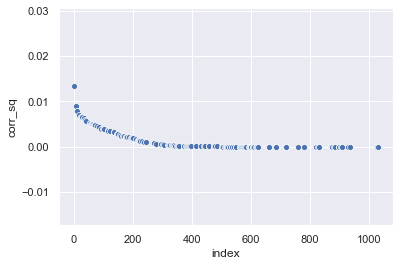

In [66]:
sns.scatterplot(x='index', y='corr_sq',alpha=1, data=corr_df[corr_df.KRT_TF])

Results: we can see that the correlation between expression of KRT genes and TFs footprinting features is quite low, furthermore there seems to not be an association beween the r^2 rank and whether or not the KRT feature is contains a KRT tf (manually annotated)

In [67]:
# KRT_crm['SOX13_loop'].describe()

In [68]:
# corr_df#[corr_df.KRT_TF]

## next we see if the KRT tfs are significantly enriched in KRT genes

In [199]:
KRT_crm.shape

(8812, 1057)

In [192]:
results = {}
count_all = data_all.sum().sum()
count_KRTgene = KRT_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row
for tf, feat_list in KRT_TF_dict.items():
    if len(feat_list)>0:
#         print(tf)
        KRT_crm_KRT_genes = KRT_crm[feat_list]
        count_KRTtf_KRTgene = KRT_crm_KRT_genes.sum().sum() # A
        count_KRTtf = data_all[feat_list].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
        count_KRTtf_neg = count_KRTtf - count_KRTtf_KRTgene # B
        count_neg_KRTgene = count_KRTgene - count_KRTtf_KRTgene #C
        count_neg_neg = count_all - count_KRTgene - count_KRTtf_neg #D
        mat_counts = np.array([[count_KRTtf_KRTgene,count_neg_KRTgene],
                       [count_KRTtf_neg, count_neg_neg]]).reshape((2,2))
        pseudo = 1
        mat_counts_pseudo = mat_counts+pseudo
        num_in_1 = mat_counts.sum(axis=1)[0] #count_KRTgene
        num_in_2 = mat_counts.sum(axis=0)[0] #count_KRTtf
        in_1_and_in_2 = count_KRTtf_KRTgene
        in_1_or_in_2 = count_KRTgene +count_KRTtf_neg
        in_1 = count_KRTgene
        in_2 = count_KRTtf
        observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
        expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
        oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
        jaccard = in_1_and_in_2/in_1_or_in_2
        intersect_over_min = in_1_and_in_2/min(in_1,in_2)

        results[tf] = { 'jaccard':jaccard,'intersect_over_min':intersect_over_min,
                                'intersection':in_1_and_in_2, 
                               'union':in_1_or_in_2, 
                               'num_in_1':num_in_1,'num_in_2':num_in_2,
                               'observed':observed_num, 'expected':expected_num, 
                               'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
        

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [196]:
result_df = pd.DataFrame.from_dict(results,orient='index')
result_df['pval_bonf'] = result_df.pval.apply(lambda x: min(1, x* sum(sum(mat_counts))))#result_df.shape[0]))
result_df['log_pval_bonf'] = result_df.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
result_df.to_csv(os.path.join(save_dir, 'stats_fisher_KRTtfs.csv'))
display(result_df[:5])
result_df.shape

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
ATF1,0.000629,0.063990,620.0,985681.0,976612.0,9689.0,620.0,620.928072,0.999901,5.068236e-01,1.000000e+00,-0.000000
ATF2,0.005635,0.097857,5805.0,1030128.0,976612.0,59321.0,5805.0,3801.638366,1.587870,1.165865e-216,1.776674e-209,100.000000
ATF3,0.001132,0.063831,1124.0,993097.0,976612.0,17609.0,1124.0,1128.488225,0.996571,5.487075e-01,1.000000e+00,-0.000000
ATF4,0.001546,0.106769,1530.0,989412.0,976612.0,14330.0,1530.0,918.350631,1.747815,2.632551e-82,4.011775e-75,74.396663
BARX2,0.021119,0.180372,22814.0,1080281.0,976612.0,126483.0,22814.0,8105.774102,3.266916,0.000000e+00,0.000000e+00,100.000000


(80, 12)

In [198]:
result_df_filt

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
ATF2,0.005635,0.097857,5805.0,1030128.0,976612.0,59321.0,5805.0,3801.638366,1.587870,1.165865e-216,1.776674e-209,100.000000
ATF4,0.001546,0.106769,1530.0,989412.0,976612.0,14330.0,1530.0,918.350631,1.747815,2.632551e-82,4.011775e-75,74.396663
BARX2,0.021119,0.180372,22814.0,1080281.0,976612.0,126483.0,22814.0,8105.774102,3.266916,0.000000e+00,0.000000e+00,100.000000
CEBPG,0.001921,0.113969,1905.0,991422.0,976612.0,16715.0,1905.0,1071.195450,1.881085,8.226079e-127,1.253582e-119,100.000000
DLX3,0.000376,0.144201,368.0,978796.0,976612.0,2552.0,368.0,163.547161,2.466865,3.309333e-47,5.043131e-40,39.297300
DLX5,0.000524,0.219700,513.0,978434.0,976612.0,2335.0,513.0,149.640525,4.119290,2.157259e-133,3.287471e-126,100.000000
ELF5,0.002984,1.000000,2914.0,976612.0,976612.0,2914.0,2914.0,186.746248,42698.201647,0.000000e+00,0.000000e+00,100.000000
ESRRA,0.000774,0.153955,759.0,980783.0,976612.0,4930.0,759.0,315.943378,2.661664,9.671662e-109,1.473876e-101,99.940290
FOS,0.005667,0.094890,5851.0,1032422.0,976612.0,61661.0,5851.0,3951.599321,1.534492,1.021484e-189,1.556651e-182,100.000000
FOSL1,0.004316,0.096712,4392.0,1017633.0,976612.0,45413.0,4392.0,2910.331976,1.566478,5.647902e-156,8.606902e-149,100.000000


In [ ]:
# # for all
# KRT_crm = data_all[tissues_label=='GDSD6']
# KRT_crm_KRT_genes = KRT_crm[KRT_TF_feat]
# count_KRTtf_KRTgene = KRT_crm_KRT_genes.sum().sum() # A
# count_all = data_all.sum().sum()
# count_KRTgene = KRT_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row
# count_KRTtf = data_all[KRT_TF_feat].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
# count_KRTtf_neg = count_KRTtf - count_KRTtf_KRTgene # B
# count_neg_KRTgene = count_KRTgene - count_KRTtf_KRTgene #C
# count_neg_neg = count_all - count_KRTgene - count_KRTtf_neg #D


# mat_counts = np.array([[count_KRTtf_KRTgene,count_neg_KRTgene],
#                        [count_KRTtf_neg, count_neg_neg]]).reshape((2,2))
# pseudo = 1
# mat_counts_pseudo = mat_counts+pseudo
# num_in_1 = mat_counts.sum(axis=1)[0] #count_KRTgene
# num_in_2 = mat_counts.sum(axis=0)[0] #count_KRTtf
# in_1_and_in_2 = count_KRTtf_KRTgene
# in_1_or_in_2 = count_KRTgene +count_KRTtf_neg
# in_1 = count_KRTgene
# in_2 = count_KRTtf
# observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
# expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
# oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
# jaccard = in_1_and_in_2/in_1_or_in_2
# intersect_over_min = in_1_and_in_2/min(in_1,in_2)

# results = { 'jaccard':jaccard,'intersect_over_min':intersect_over_min,
#                         'intersection':in_1_and_in_2, 
#                        'union':in_1_or_in_2, 
#                        'num_in_1':num_in_1,'num_in_2':num_in_2,
#                        'observed':observed_num, 'expected':expected_num, 
#                        'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
# # results

do some excel work:see pptx

## next we check which tf footprints are significantly associated with having KRT genes be expressed

In [88]:
# expression
KRT_exp_crm = KRT_crm.iloc[np.where(np.array(KRT_exp_arr)>THRES)[0],:]


In [89]:
results = {}
count_all = KRT_crm.sum().sum()
count_KRTgene = KRT_exp_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row
for tf, feat_list in tfs_feat_dict.items():
    if len(feat_list)>0:
#         print(tf)
        KRT_crm_KRT_genes = KRT_exp_crm[feat_list]
        count_KRTtf_KRTgene = KRT_crm_KRT_genes.sum().sum() # A
        if count_KRTtf_KRTgene==0:
            continue
        count_KRTtf = KRT_crm[feat_list].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
        count_KRTtf_neg = count_KRTtf - count_KRTtf_KRTgene # B
        count_neg_KRTgene = count_KRTgene - count_KRTtf_KRTgene #C
        count_neg_neg = count_all - count_KRTgene - count_KRTtf_neg #D
        mat_counts = np.array([[count_KRTtf_KRTgene,count_neg_KRTgene],
                       [count_KRTtf_neg, count_neg_neg]]).reshape((2,2))
        pseudo = 1
        mat_counts_pseudo = mat_counts+pseudo
        num_in_1 = mat_counts.sum(axis=1)[0] #count_KRTgene
        num_in_2 = mat_counts.sum(axis=0)[0] #count_KRTtf
        in_1_and_in_2 = count_KRTtf_KRTgene
        in_1_or_in_2 = count_KRTgene +count_KRTtf_neg
        in_1 = count_KRTgene
        in_2 = count_KRTtf
        observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
        expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
        oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
        jaccard = in_1_and_in_2/in_1_or_in_2
        intersect_over_min = in_1_and_in_2/min(in_1,in_2)

        results[tf] = { 'jaccard':jaccard,'intersect_over_min':intersect_over_min,
                                'intersection':in_1_and_in_2, 
                               'union':in_1_or_in_2, 
                               'num_in_1':num_in_1,'num_in_2':num_in_2,
                               'observed':observed_num, 'expected':expected_num, 
                               'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
        

In [97]:
result_df_exp = pd.DataFrame.from_dict(results,orient='index')
result_df_exp['pval_bonf'] = result_df_exp.pval.apply(lambda x: min(1, x* result_df.shape[0]))
result_df_exp['log_pval_bonf'] = result_df_exp.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
result_df_exp['is_KRT_TF'] = result_df_exp.index.isin(KRT_tfs)
result_df_exp.to_csv(os.path.join(save_dir, 'stats_fisher_KRTexp.csv'))
result_df_exp.sort_values('oddsratio',ascending=False)

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf,is_KRT_TF
CDC5L,0.000379,0.507042,144.0,380069.0,379929.0,284.0,144.0,110.483832,1.615297,0.000034,0.002723,2.564925,False
AHR,0.000334,0.500000,127.0,380056.0,379929.0,254.0,127.0,98.813005,1.570701,0.000202,0.016170,1.791293,False
FOXQ1,0.000952,0.471969,362.0,380334.0,379929.0,767.0,362.0,298.384152,1.404561,0.000002,0.000139,3.858248,False
CUX1,0.000295,0.466667,112.0,380057.0,379929.0,240.0,112.0,93.366618,1.375829,0.008168,0.653401,0.184820,False
SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,0.327209,0.485175,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEBPZ,0.001645,0.337097,627.0,381162.0,379929.0,1860.0,627.0,723.591293,0.798922,0.999998,1.000000,-0.000000,False
NFYB,0.001776,0.336816,677.0,381262.0,379929.0,2010.0,677.0,781.945430,0.797844,0.999999,1.000000,-0.000000,False
ZNF768,0.001121,0.335956,427.0,380773.0,379929.0,1271.0,427.0,494.454050,0.795246,0.999958,1.000000,-0.000000,False
CREB3,0.000851,0.334365,324.0,380574.0,379929.0,969.0,324.0,376.967722,0.789937,0.999799,1.000000,-0.000000,False


In [98]:
result_df_exp.sort_values('oddsratio',ascending=False)[:10]

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf,is_KRT_TF
CDC5L,0.000379,0.507042,144.0,380069.0,379929.0,284.0,144.0,110.483832,1.615297,0.000034,0.002723,2.564925,False
AHR,0.000334,0.500000,127.0,380056.0,379929.0,254.0,127.0,98.813005,1.570701,0.000202,0.016170,1.791293,False
FOXQ1,0.000952,0.471969,362.0,380334.0,379929.0,767.0,362.0,298.384152,1.404561,0.000002,0.000139,3.858248,False
CUX1,0.000295,0.466667,112.0,380057.0,379929.0,240.0,112.0,93.366618,1.375829,0.008168,0.653401,0.184820,False
SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,0.327209,0.485175,True
ZNF317,0.000434,0.455801,165.0,380126.0,379929.0,362.0,165.0,140.827983,1.316828,0.005375,0.429973,0.366559,False
CEBPD,0.001114,0.452991,424.0,380441.0,379929.0,936.0,424.0,364.129812,1.301441,0.000037,0.002974,2.526607,False
NFATC3,0.000939,0.450189,357.0,380365.0,379929.0,793.0,357.0,308.498869,1.286866,0.000247,0.019778,1.703816,False
FOXC1,0.001353,0.448606,515.0,380562.0,379929.0,1148.0,515.0,446.603658,1.278584,0.000021,0.001709,2.767171,False
HOXA5,0.000718,0.448276,273.0,380265.0,379929.0,609.0,273.0,236.917794,1.277112,0.001581,0.126482,0.897970,False


In [ ]:


# results[result_idx] = {'color_row':color_1, 'color_col':color_2,
#                        'jaccard':jaccard,'intersect_over_min':intersect_over_min,
#                         'intersection':len(in_1_and_in_2), 
#                        'union':len(in_1_or_in_2), 
#                        'num_in_1':num_in_1,'num_in_2':num_in_2,
#                        'observed':observed_num, 'expected':expected_num, 
#                        'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}

In [ ]:
# sns.distplot(KRT_crm_KRT_genes['JUND_loop'])

In [ ]:
# def comp_two_gene_dicts(gene_dict1, gene_dict2, pseudo=0):
#     """
#     1: rows
#     2: columns
#     """
#     bg = set(gene_dict1['background']) | set(gene_dict2['background'])
    
#     results = {}
#     result_idx = 0
#     for color_1 in ['purple','green', 'grey', 'blue']:
#         for color_2 in ['purple','green', 'grey', 'blue']:
#             geneset_1 = set(gene_dict1[color_1])
#             geneset_2 = set(gene_dict2[color_2])
            
            
#             in_1_and_in_2 = geneset_1 & geneset_2
#             in_1_not_2 = geneset_1 - geneset_2
#             not_1_in_2 = geneset_2 - geneset_1
#             in_1_or_in_2 = geneset_1 | geneset_2
#             not_1_not_2 = bg - in_1_or_in_2
            
#             mat_counts = np.array([[len(in_1_and_in_2), len(in_1_not_2)],
#                                   [len(not_1_in_2), len(not_1_not_2)]]).reshape((2,2))
#             mat_counts_pseudo = mat_counts+pseudo
# #             if (color_1=='grey') & (color_2=='grey'):
# #                 print(mat_counts)
    
#             num_in_1 = mat_counts.sum(axis=1)[0]
#             num_in_2 = mat_counts.sum(axis=0)[0]
#             observed_num = mat_counts[0][0]
#             expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
#             oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
#             jaccard = len(in_1_and_in_2)/len(in_1_or_in_2)
#             intersect_over_min = len(in_1_and_in_2)/min(num_in_1,num_in_2)
            
#             results[result_idx] = {'color_row':color_1, 'color_col':color_2,
#                                    'jaccard':jaccard,'intersect_over_min':intersect_over_min,
#                                     'intersection':len(in_1_and_in_2), 
#                                    'union':len(in_1_or_in_2), 
#                                    'num_in_1':num_in_1,'num_in_2':num_in_2,
#                                    'observed':observed_num, 'expected':expected_num, 
#                                    'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
    
#             result_idx+=1
#     result_df = pd.DataFrame.from_dict(results,orient='index')
#     result_df['pval_bonf'] = result_df.pval.apply(lambda x: min(1, x* sum(sum(mat_counts))))#result_df.shape[0]))
#     result_df['log_pval_bonf'] = result_df.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
#     return result_df

# 2. check relationship between TFAP2C and KLF4

In [104]:
cols_to_check=['TFAP2C_pro','TFAP2C_loop','KLF4_pro','KLF4_loop']

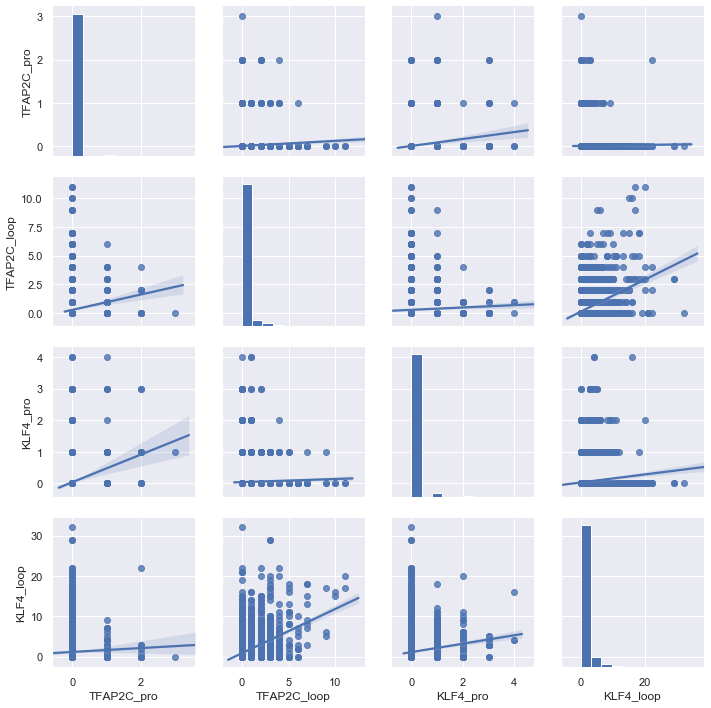

In [107]:
f = sns.pairplot(KRT_crm[cols_to_check],kind='reg')
plt.savefig(os.path.join(save_dir, 'TFAP2C_KLF4_corr_check.png'))

# 5. Next check would be for pairs of KRT tfs to see which are significantly enriched in KRT genes

In [110]:
tfs_w_feats = set()
for col in data_all.columns:
    tfs_w_feats.add(col.split('_')[0])
len(tfs_w_feats)  

529

In [134]:
KRT_TF_pair_dict = defaultdict(list)
for tf1 in KRT_tfs:
    for tf2 in KRT_tfs:
        if (tf1<tf2):
            if (tf1 in tfs_w_feats) and (tf2 in tfs_w_feats):
                possible_feats = [tf1+'_pro',tf1+'_loop',tf2+'_pro',tf2+'_loop']
                for feat in possible_feats:
                    if feat in data_all.columns:
                        KRT_TF_pair_dict[tf1+'::'+tf2].append(feat)
    #                 KRT_TF_pair_dict[tf1+'::'+tf2]=[]
len(KRT_TF_pair_dict)
# for key, list_feat in KRT_TF_pair_dict.items():
#     if len(list_feat)<4:
#         print(key, list_feat)

3081

In [135]:
%%time
counter = 0
results = {}
count_all = data_all.sum().sum()
count_KRTgene = KRT_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row

for tf, feat_list in KRT_TF_pair_dict.items():
    if len(feat_list)>0:
        counter+=1
        if (counter%100)==0:
            print(counter, tf)
#         print(tf)
        KRT_crm_KRT_genes = KRT_crm[feat_list]
        count_KRTtf_KRTgene = KRT_crm_KRT_genes.sum().sum() # A
        count_KRTtf = data_all[feat_list].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
        count_KRTtf_neg = count_KRTtf - count_KRTtf_KRTgene # B
        count_neg_KRTgene = count_KRTgene - count_KRTtf_KRTgene #C
        count_neg_neg = count_all - count_KRTgene - count_KRTtf_neg #D
        mat_counts = np.array([[count_KRTtf_KRTgene,count_neg_KRTgene],
                       [count_KRTtf_neg, count_neg_neg]]).reshape((2,2))
        pseudo = 1
        mat_counts_pseudo = mat_counts+pseudo
        num_in_1 = mat_counts.sum(axis=1)[0] #count_KRTgene
        num_in_2 = mat_counts.sum(axis=0)[0] #count_KRTtf
        in_1_and_in_2 = count_KRTtf_KRTgene
        in_1_or_in_2 = count_KRTgene +count_KRTtf_neg
        in_1 = count_KRTgene
        in_2 = count_KRTtf
        observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
        expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
        oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
        jaccard = in_1_and_in_2/in_1_or_in_2
        intersect_over_min = in_1_and_in_2/min(in_1,in_2)

        results[tf] = { 'jaccard':jaccard,'intersect_over_min':intersect_over_min,
                                'intersection':in_1_and_in_2, 
                               'union':in_1_or_in_2, 
                               'num_in_1':num_in_1,'num_in_2':num_in_2,
                               'observed':observed_num, 'expected':expected_num, 
                               'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
        

100 ATF2::HES1
200 ATF3::POU3F3
300 ATF4::TFDP1
400 CEBPG::HOXA1
500 DLX3::PRRX1
600 E2F1::ELF5
700 E2F3::POU2F2
800 E2F4::XBP1
900 ELF5::POU2F1
1000 ESRRA::ZEB1
1100 ETV4::POU5F1
1200 FOSL1::HOXC13
1300 FOSL2::TCF4
1400 FOXP1::POU5F1
1500 GRHL2::NR3C1
1600 HOMEZ::IRX2
1700 HOXA1::XBP1
1800 HOXC13::TFDP1
1900 JUN::TP63
2000 JUND::ZNF219
2100 KLF5::POU2F2
2200 MAFB::SMAD4
2300 OTX1::ZEB1
2400 PBX2::SP1
2500 POU2F3::SMAD4
2600 POU3F3::SOX9


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


2700 POU5F1::XBP1
2800 RARG::TP63
2900 SOX11::TCF7L2
3000 STAT1::XBP1
CPU times: user 7min 21s, sys: 18.5 s, total: 7min 39s
Wall time: 1min 3s


In [136]:
result_df = pd.DataFrame.from_dict(results,orient='index')
result_df['pval_bonf'] = result_df.pval.apply(lambda x: min(1, x* sum(sum(mat_counts))))#result_df.shape[0]))
result_df['log_pval_bonf'] = result_df.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
result_df.to_csv(os.path.join(save_dir, 'stats_fisher_KRTtfs_pairs.csv'))
result_df

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
ATF1::ATF2,0.006183,0.093102,6425.0,1039197.0,976612.0,69010.0,6425.0,4422.566438,1.502773,9.674568e-190,1.474318e-182,100.000000
ATF1::ATF3,0.001740,0.063887,1744.0,1002166.0,976612.0,27298.0,1744.0,1749.416297,0.997218,5.482827e-01,1.000000e+00,-0.000000
ATF1::ATF4,0.002153,0.089512,2150.0,998481.0,976612.0,24019.0,2150.0,1539.278703,1.437327,6.841714e-53,1.042617e-45,44.981875
ATF1::BARX2,0.021512,0.172091,23434.0,1089350.0,976612.0,136172.0,23434.0,8726.702173,3.085784,0.000000e+00,0.000000e+00,100.000000
ATF1::CEBPG,0.002524,0.095629,2525.0,1000491.0,976612.0,26404.0,2525.0,1692.123522,1.546211,4.771992e-86,7.272092e-79,78.138341
...,...,...,...,...,...,...,...,...,...,...,...,...
XBP1::ZEB1,0.001533,0.047803,1544.0,1007367.0,976612.0,32299.0,1544.0,2069.909772,0.733198,1.000000e+00,1.000000e+00,-0.000000
XBP1::ZNF219,0.008320,0.063212,9268.0,1113961.0,976612.0,146617.0,9268.0,9396.079169,0.985408,9.146486e-01,1.000000e+00,-0.000000
ZBTB7B::ZEB1,0.001327,0.055584,1326.0,999142.0,976612.0,23856.0,1326.0,1528.832705,0.859938,1.000000e+00,1.000000e+00,-0.000000
ZBTB7B::ZNF219,0.008185,0.065497,9050.0,1105736.0,976612.0,138174.0,9050.0,8855.002101,1.023889,1.577764e-02,1.000000e+00,-0.000000


In [146]:
result_df_filt = result_df[(result_df.pval_bonf<0.05) & (result_df.oddsratio>1)& (result_df.oddsratio<1000)]
print(result_df_filt.shape, result_df.shape)
result_df_filt.sort_values('oddsratio',ascending=False)[:10]

(1851, 12) (3081, 12)


,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
ELF5::POU6F1,0.002983,0.967463,2914.0,976710.0,976612.0,3012.0,2914.0,193.026664,431.292003,0.0,0.0,100.0
ELF5::POU3F3,0.002983,0.955410,2914.0,976748.0,976612.0,3050.0,2914.0,195.461928,311.662734,0.0,0.0,100.0
ELF5::PBX2,0.002983,0.946104,2914.0,976778.0,976612.0,3080.0,2914.0,197.384504,255.674878,0.0,0.0,100.0
ELF5::POU3F4,0.002983,0.943959,2914.0,976785.0,976612.0,3087.0,2914.0,197.833105,245.388987,0.0,0.0,100.0
ELF5::POU3F2,0.002983,0.925961,2914.0,976845.0,976612.0,3147.0,2914.0,201.678258,182.467966,0.0,0.0,100.0
POU2F3::POU6F1,0.000986,0.907634,963.0,976710.0,976612.0,1061.0,963.0,67.995117,142.344455,0.0,0.0,100.0
ELF5::SOX11,0.002983,0.883030,2914.0,976998.0,976612.0,3300.0,2914.0,211.483397,110.328284,0.0,0.0,100.0
ELF5::HOXC11,0.003502,0.880824,3422.0,977075.0,976612.0,3885.0,3422.0,248.973636,108.111647,0.0,0.0,100.0
POU2F3::POU3F3,0.000986,0.876251,963.0,976748.0,976612.0,1099.0,963.0,70.430380,102.861778,0.0,0.0,100.0
PBX2::POU2F3,0.000986,0.852967,963.0,976778.0,976612.0,1129.0,963.0,72.352956,84.383436,0.0,0.0,100.0


In [147]:
result_mat_df = pd.DataFrame(index=KRT_tfs, columns = KRT_tfs).fillna(0)
for pair in result_df_filt.index.values:
    tf1,tf2 = pair.split('::')
    result_mat_df.at[tf1,tf2]=1
    result_mat_df.at[tf2,tf1]=1
result_mat_df.to_csv(os.path.join(save_dir, 'stats_fisher_KRTtfs_pairs_mat.csv'))

## KRT gene pairs with expression

In [176]:
counter = 0
results = {}
count_all = KRT_crm.sum().sum()
count_KRTgene = KRT_exp_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row
for tf, feat_list in KRT_TF_pair_dict.items():
    if len(feat_list)>0:
        counter+=1
        if (counter%100)==0:
            print(counter, tf)
#         print(tf)
        KRT_crm_KRT_genes = KRT_exp_crm[feat_list]
        count_KRTtf_KRTgene = KRT_crm_KRT_genes.sum().sum() # A
        if count_KRTtf_KRTgene==0:
            continue
        count_KRTtf = KRT_crm[feat_list].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
        count_KRTtf_neg = count_KRTtf - count_KRTtf_KRTgene # B
        count_neg_KRTgene = count_KRTgene - count_KRTtf_KRTgene #C
        count_neg_neg = count_all - count_KRTgene - count_KRTtf_neg #D
        mat_counts = np.array([[count_KRTtf_KRTgene,count_neg_KRTgene],
                       [count_KRTtf_neg, count_neg_neg]]).reshape((2,2))
        pseudo = 1
        mat_counts_pseudo = mat_counts+pseudo
        num_in_1 = mat_counts.sum(axis=1)[0] #count_KRTgene
        num_in_2 = mat_counts.sum(axis=0)[0] #count_KRTtf
        in_1_and_in_2 = count_KRTtf_KRTgene
        in_1_or_in_2 = count_KRTgene +count_KRTtf_neg
        in_1 = count_KRTgene
        in_2 = count_KRTtf
        observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
        expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
        oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
        jaccard = in_1_and_in_2/in_1_or_in_2
        intersect_over_min = in_1_and_in_2/min(in_1,in_2)

        results[tf] = { 'jaccard':jaccard,'intersect_over_min':intersect_over_min,
                                'intersection':in_1_and_in_2, 
                               'union':in_1_or_in_2, 
                               'num_in_1':num_in_1,'num_in_2':num_in_2,
                               'observed':observed_num, 'expected':expected_num, 
                               'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
        

100 ATF2::HES1
200 ATF3::POU3F3
300 ATF4::TFDP1
400 CEBPG::HOXA1
500 DLX3::PRRX1
600 E2F1::ELF5
700 E2F3::POU2F2
800 E2F4::XBP1
900 ELF5::POU2F1
1000 ESRRA::ZEB1
1100 ETV4::POU5F1
1200 FOSL1::HOXC13
1300 FOSL2::TCF4
1400 FOXP1::POU5F1
1500 GRHL2::NR3C1
1600 HOMEZ::IRX2
1700 HOXA1::XBP1
1800 HOXC13::TFDP1
1900 JUN::TP63
2000 JUND::ZNF219
2100 KLF5::POU2F2
2200 MAFB::SMAD4
2300 OTX1::ZEB1
2400 PBX2::SP1
2500 POU2F3::SMAD4
2600 POU3F3::SOX9
2700 POU5F1::XBP1
2800 RARG::TP63
2900 SOX11::TCF7L2
3000 STAT1::XBP1


In [177]:
result_df = pd.DataFrame.from_dict(results,orient='index')
result_df['pval_bonf'] = result_df.pval.apply(lambda x: min(1, x* sum(sum(mat_counts))))#result_df.shape[0]))
result_df['log_pval_bonf'] = result_df.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
result_df.to_csv(os.path.join(save_dir, 'stats_fisher_KRTtfs_exp_pairs.csv'))
result_df

,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
ATF1::ATF2,0.006836,0.408249,2623.0,383731.0,379929.0,6425.0,2623.0,2499.502182,1.084204,8.025401e-04,1.000000e+00,-0.000000
ATF1::ATF3,0.001714,0.374427,653.0,381020.0,379929.0,1744.0,653.0,678.464094,0.940477,8.972327e-01,1.000000e+00,-0.000000
ATF1::ATF4,0.002261,0.400930,862.0,381217.0,379929.0,2150.0,862.0,836.409290,1.051591,1.313541e-01,1.000000e+00,-0.000000
ATF1::BARX2,0.024643,0.413971,9701.0,393662.0,379929.0,23434.0,9701.0,9116.472239,1.112310,1.440061e-15,1.406381e-09,8.851897
ATF1::CEBPG,0.002648,0.400000,1010.0,381444.0,379929.0,2525.0,1010.0,982.294632,1.047478,1.313224e-01,1.000000e+00,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
XBP1::ZEB1,0.001520,0.375000,579.0,380894.0,379929.0,1544.0,579.0,600.658579,0.942868,8.740893e-01,1.000000e+00,-0.000000
XBP1::ZNF219,0.008855,0.368580,3416.0,385781.0,379929.0,9268.0,3416.0,3605.507583,0.916114,9.999770e-01,1.000000e+00,-0.000000
ZBTB7B::ZEB1,0.001287,0.369532,490.0,380765.0,379929.0,1326.0,490.0,515.850567,0.921188,9.297955e-01,1.000000e+00,-0.000000
ZBTB7B::ZNF219,0.008627,0.367624,3327.0,385652.0,379929.0,9050.0,3327.0,3520.699572,0.912344,9.999875e-01,1.000000e+00,-0.000000


In [180]:
result_df_filt = result_df[(result_df.pval<0.05) & (result_df.oddsratio>1)& (result_df.oddsratio<1000)]
print(result_df_filt.shape, result_df.shape)
result_df_filt.sort_values('oddsratio',ascending=False)[:50]

(884, 12) (2961, 12)


,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
POU5F1::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
PRRX1::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
POU3F1::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
POU3F2::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
POU3F3::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
PBX2::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
POU3F4::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
E2F1::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
PBX1::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0
FOXF2::SOX7,0.000442,0.457766,168.0,380128.0,379929.0,367.0,168.0,142.773121,1.327226,0.004090,1.0,-0.0


In [181]:
result_df_filt.loc['KLF4::TFAP2C',:]

KeyError: 'KLF4::TFAP2C'

# 5. Next check stability score found interactions and annotate # of KRT tfs each interaction has

In [148]:
score_thres=.2

In [155]:
def check_interaction(interaction_str):
    feat_arr = interaction_str.split('::')
    num_KRT = 0
    num_tot = len(feat_arr)
    for feat in feat_arr:
        if feat in KRT_TF_feat:
            num_KRT+=1
    return [num_KRT,num_tot]

In [170]:
# GDSD6_stability_df = pd.read_csv('../data/processed/fig4_modelling/irf_manual/test_GDSD6_GDSD6_boosted_stability_score.csv')
GDSD6_stability_df = pd.read_csv('../data/processed/fig4_modelling/irf_manual/test_GDSD6_purple_boosted_stability_score.csv')
GDSD6_stability_df

,index,score,std,count
0,AHR_loop,0.102030,NaN,1
1,AHR_pro::ELF3_pro::HOXD8_pro::HOXD9_pro::MAFG_...,0.034010,NaN,1
2,AHR_pro::FOS_pro::MEF2D_pro::PATZ1_pro::STAT5B...,0.034010,NaN,1
3,AHR_pro::FOS_pro::NR1I3_pro::PATZ1_pro::TCF7L2...,0.034010,NaN,1
4,AHR_pro::MAFG_pro::MEF2D_pro::NR1I3_pro::STAT5...,0.034010,NaN,1
...,...,...,...,...
2278,ZBTB17_pro::NKX2-1_loop,0.033654,NaN,1
2279,ZBTB4_pro,0.033654,NaN,1
2280,ZKSCAN3_pro,0.033476,NaN,1
2281,ZNF121_pro::ETS1_loop,0.033476,NaN,1


In [171]:
GDSD6_stability_df[['num_KRT','num_in_interaction']]=GDSD6_stability_df['index'].apply(func=check_interaction).apply(pd.Series)#,result_type='expand')


In [172]:
GDSD6_stability_df['frac_KRT'] = GDSD6_stability_df['num_KRT']/GDSD6_stability_df['num_in_interaction']

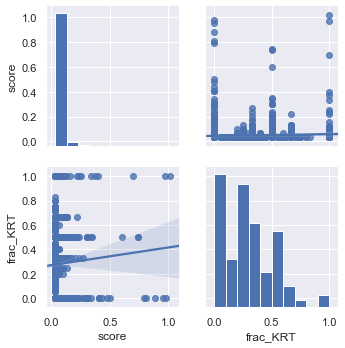

In [173]:
sns.pairplot(GDSD6_stability_df[['score','frac_KRT']],kind='reg')

In [174]:
GDSD6_stability_df[(GDSD6_stability_df.score >score_thres)]


,index,score,std,count,num_KRT,num_in_interaction,frac_KRT
23,ATF1_loop,0.221866,NaN,1,1,1,1.000000
433,IRF6_pro,0.285256,NaN,1,0,1,0.000000
436,IRF6_pro::JUNB_pro,0.348647,NaN,1,1,2,0.500000
562,JUNB_pro,0.697293,NaN,1,1,1,1.000000
596,JUNB_pro::MYNN_pro,0.602208,NaN,1,1,2,0.500000
633,JUNB_pro::MYNN_pro::SOX7_pro,0.221866,NaN,1,2,3,0.666667
808,MAFG_pro::NR1I3_pro,0.204060,NaN,1,0,2,0.000000
833,MEF2D_pro,0.476140,NaN,1,0,1,0.000000
846,MEF2D_pro::NR1I3_pro,0.884259,NaN,1,0,2,0.000000
851,MEF2D_pro::NR1I3_pro::DLX3_loop,0.272080,NaN,1,1,3,0.333333


In [175]:
GDSD6_stability_df[(GDSD6_stability_df.frac_KRT>0) & (GDSD6_stability_df.score >score_thres)]

,index,score,std,count,num_KRT,num_in_interaction,frac_KRT
23,ATF1_loop,0.221866,NaN,1,1,1,1.000000
436,IRF6_pro::JUNB_pro,0.348647,NaN,1,1,2,0.500000
562,JUNB_pro,0.697293,NaN,1,1,1,1.000000
596,JUNB_pro::MYNN_pro,0.602208,NaN,1,1,2,0.500000
633,JUNB_pro::MYNN_pro::SOX7_pro,0.221866,NaN,1,2,3,0.666667
851,MEF2D_pro::NR1I3_pro::DLX3_loop,0.272080,NaN,1,1,3,0.333333
910,MEF2D_pro::NR1I3_pro::TCF7L2_pro,0.204060,NaN,1,1,3,0.333333
1061,MYBL2_pro::PBX2_pro,0.236823,NaN,1,1,2,0.500000
1255,MYNN_pro::ATF1_loop,0.221866,NaN,1,1,2,0.500000
1310,MYNN_pro::SOX7_pro,0.221866,NaN,1,1,2,0.500000


# SKIN trajectory analysis

In [184]:
# rna
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
rna_df_norm = rna_df[normal_tissues]
rna_D0_dict = pd.Series(rna_df.GDSD0.values, index=rna_df.index.values).to_dict()
rna_D3_dict = pd.Series(rna_df.GDSD3.values, index=rna_df.index.values).to_dict()
rna_D6_dict = pd.Series(rna_df.GDSD6.values, index=rna_df.index.values).to_dict()

In [186]:
%%time
D0_crm = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/pro_loop_tissue/GDSD0_crm.csv',index_col=0,header=0)
D0_crm.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

D3_crm = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/pro_loop_tissue/GDSD3_crm.csv',index_col=0,header=0)
D3_crm.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

D6_crm = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/pro_loop_tissue/GDSD6_crm.csv',index_col=0,header=0)
D6_crm.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)


In [ ]:
what genes

In [187]:

D0_crm

,AHR_pro,ARID3A_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,...,ZNF524_loop,ZNF528_loop,ZNF554_loop,ZNF563_loop,ZNF652_loop,ZNF680_loop,ZNF768_loop,ZNF770_loop,ZNF816_loop,ZNF85_loop
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
